In [1]:
import logging
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from tqdm import tqdm
from lshgrouping import LSHGrouping

logging.basicConfig(format='[%(asctime)s] %(message)s', level=logging.INFO)

# Reading input molecules

The following lines read the SMILES strings for some examplary compounds.

In [2]:
smiles = []
with open('compounds.smi', 'r') as fh:
    for ln in fh:
        smiles.append(ln.split('\t')[0])

# Generating fingerprints

To cluster the compounds, we calculate binary fingerprints.
In the given example Morgan3 fingerprints of 2048 it length are used,
but in reality any binary fingerprint will work.

In [3]:
def smiles2fp(smi: str) -> np.ndarray:
    mol = Chem.MolFromSmiles(smi)
    fpgen = GetMorganGenerator(radius=3, fpSize=2048)
    return fpgen.GetFingerprintAsNumPy(mol)

X = [smiles2fp(smi) for smi in tqdm(smiles)]
X = np.stack(X, axis=0)
X.shape

  0%|          | 0/181 [00:00<?, ?it/s]

100%|██████████| 181/181 [00:00<00:00, 4353.73it/s]


(181, 2048)

# Cluster compounds

In [4]:
lsh = LSHGrouping(
    num_perm=128, 
    lsh_threshold=.5, 
    verbosity=2, 
    n_jobs=4)
clust_assign = lsh.fit_predict(X)

2025-06-26 10:21:59,374 - LSHGrouping - INFO - Fitting LSHGrouping to 181 samples.
[2025-06-26 10:21:59,374] Fitting LSHGrouping to 181 samples.
2025-06-26 10:21:59,379 - LSHGrouping - DEBUG - Generating MinHashes...
[2025-06-26 10:21:59,379] Generating MinHashes...
MinHashing: 100%|██████████| 181/181 [00:00<00:00, 269.50it/s]
2025-06-26 10:22:00,102 - LSHGrouping - DEBUG - Building LSH index...
[2025-06-26 10:22:00,102] Building LSH index...
Indexing: 100%|██████████| 181/181 [00:00<00:00, 30756.76it/s]
2025-06-26 10:22:00,123 - LSHGrouping - DEBUG - Querying for LSH neighbors...
[2025-06-26 10:22:00,123] Querying for LSH neighbors...
Querying: 100%|██████████| 181/181 [00:00<00:00, 17445.74it/s]
2025-06-26 10:22:00,138 - LSHGrouping - DEBUG - Assigning cluster labels...
[2025-06-26 10:22:00,138] Assigning cluster labels...
2025-06-26 10:22:00,141 - LSHGrouping - INFO - Done. Identified 11 clusters.
[2025-06-26 10:22:00,141] Done. Identified 11 clusters.


# Visualize results

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

ndim = 48
logging.info(f'Dimensionality reduction with SVD: {X.shape[1]} -> {ndim:d}')
svd = TruncatedSVD(n_components=ndim, random_state=42)
X_embedded = svd.fit_transform(X)

ndim = 2
logging.info(f'Dimensionality reduction with tSNE: {X_embedded.shape[1]} -> {ndim:d}')
transformer = TSNE(n_components=2, random_state=42)
xy = transformer.fit_transform(X_embedded)
xy.shape

[2025-06-26 10:22:00,470] Dimensionality reduction with SVD: 2048 -> 48
[2025-06-26 10:22:00,531] Dimensionality reduction with tSNE: 48 -> 2


(181, 2)

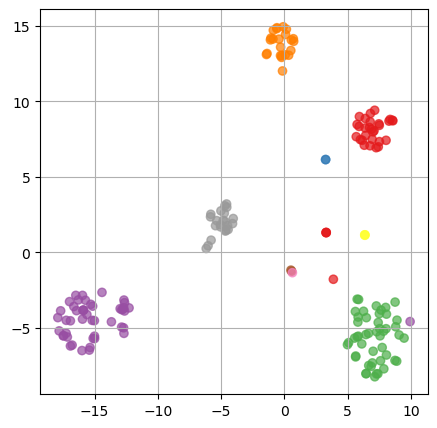

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
ax.grid()
ax.scatter(xy[:,0], xy[:,1], c=clust_assign, cmap='Set1', alpha=.7)